Importing the dependencies and loading the MNIST dataset

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
teacher_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
student_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

batch_size = 64
num_teachers = 100

num_train = len(teacher_data)
indices = list(range(num_train))
np.random.shuffle(indices)

Defining data loaders for the teacher models 600 examples per teacher    

550 - training examples    50 - test examples

In [2]:
def get_teacher_data(teacher_data, indices, i):
    train_idx, test_idx = indices[i*500:i*500+ 550], indices[i*600 + 550: (i+1)*600] 
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    teacher_train_loader = torch.utils.data.DataLoader(teacher_data, batch_size=batch_size, num_workers=0, sampler = train_sampler)
    teacher_test_loader = torch.utils.data.DataLoader(teacher_data, batch_size=batch_size, num_workers=0, sampler = test_sampler)
    return teacher_train_loader, teacher_test_loader

Visualizing the data

Text(0.5, 1.0, 'tensor(7)')

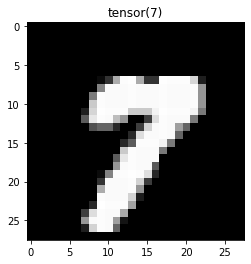

In [3]:
train_loader, test_loader = get_teacher_data(teacher_data, indices, 0)
import matplotlib.pyplot as plt
%matplotlib inline
images, labels = next(iter(train_loader))
plt.figure(figsize = (5, 4))
images = images.numpy()
i = np.random.randint(1, 64)
img = np.squeeze(images[i])
plt.imshow(img, cmap = 'gray')
plt.title(labels[i])

Checking for GPU (cuda)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Defining teacher model and initializing the models

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
teachers = [Teacher() for i in range(num_teachers)]
print(teachers)

[Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Teacher(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Teacher(
  (fc

Defining train function for teacher models

In [6]:
def train(model, train_loader, test_loader, epochs = 25, lr = 0.002, print_every = 5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    model.to(device)
    for e in range(1, epochs+1):
        train_loss = 0.0
        for images, labels in train_loader:
            #optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        train_loss /= len(train_loader.sampler)
        if e%print_every == 0:
            test_loss = 0.0
            accuracy = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                test_loss += loss.item()*images.size(0)
                _, idx = logits.topk(1, dim = 1)
                equals = idx == labels.view(*idx.shape)
                accuracy += torch.sum(equals.type(torch.FloatTensor)).item()
            accuracy /= len(test_loader.sampler)
            test_loss /= len(test_loader.sampler)
            print(f"Epoch {e}/{epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Test loss: {test_loss:.3f}.. "
                  f"Test accuracy: {accuracy:.3f}")
            
    return model

Defining hyperparameters and training the 100 teacher models 

In [7]:
epochs = 25
lr = 0.002
print_every = 5

In [8]:
for i in range(num_teachers):
    train_loader, test_loader = get_teacher_data(teacher_data, indices, i)
    print("Training teacher", i+1)
    teachers[i] = train(teachers[i], train_loader, test_loader, epochs = epochs, lr = lr, print_every = print_every)
    

Training teacher 1
Epoch 5/25.. Train loss: 2.232.. Test loss: 2.204.. Test accuracy: 0.440
Epoch 10/25.. Train loss: 1.788.. Test loss: 1.601.. Test accuracy: 0.660
Epoch 15/25.. Train loss: 0.620.. Test loss: 0.370.. Test accuracy: 0.900
Epoch 20/25.. Train loss: 0.437.. Test loss: 0.170.. Test accuracy: 0.920
Epoch 25/25.. Train loss: 0.359.. Test loss: 0.489.. Test accuracy: 0.880
Training teacher 2
Epoch 5/25.. Train loss: 2.233.. Test loss: 2.245.. Test accuracy: 0.220
Epoch 10/25.. Train loss: 1.811.. Test loss: 1.849.. Test accuracy: 0.540
Epoch 15/25.. Train loss: 0.690.. Test loss: 0.961.. Test accuracy: 0.680
Epoch 20/25.. Train loss: 0.501.. Test loss: 0.962.. Test accuracy: 0.800
Epoch 25/25.. Train loss: 0.424.. Test loss: 0.856.. Test accuracy: 0.860
Training teacher 3
Epoch 5/25.. Train loss: 2.233.. Test loss: 2.239.. Test accuracy: 0.120
Epoch 10/25.. Train loss: 1.834.. Test loss: 1.774.. Test accuracy: 0.600
Epoch 15/25.. Train loss: 0.718.. Test loss: 0.526.. Test 

Epoch 10/25.. Train loss: 1.747.. Test loss: 1.746.. Test accuracy: 0.520
Epoch 15/25.. Train loss: 0.603.. Test loss: 0.810.. Test accuracy: 0.700
Epoch 20/25.. Train loss: 0.425.. Test loss: 1.182.. Test accuracy: 0.820
Epoch 25/25.. Train loss: 0.499.. Test loss: 2.961.. Test accuracy: 0.820
Training teacher 23
Epoch 5/25.. Train loss: 2.231.. Test loss: 2.244.. Test accuracy: 0.280
Epoch 10/25.. Train loss: 1.801.. Test loss: 1.852.. Test accuracy: 0.460
Epoch 15/25.. Train loss: 0.709.. Test loss: 0.684.. Test accuracy: 0.720
Epoch 20/25.. Train loss: 0.548.. Test loss: 0.752.. Test accuracy: 0.740
Epoch 25/25.. Train loss: 0.482.. Test loss: 1.267.. Test accuracy: 0.840
Training teacher 24
Epoch 5/25.. Train loss: 2.219.. Test loss: 2.184.. Test accuracy: 0.360
Epoch 10/25.. Train loss: 1.760.. Test loss: 1.577.. Test accuracy: 0.660
Epoch 15/25.. Train loss: 0.640.. Test loss: 0.689.. Test accuracy: 0.780
Epoch 20/25.. Train loss: 0.447.. Test loss: 0.855.. Test accuracy: 0.860


Epoch 15/25.. Train loss: 0.694.. Test loss: 0.720.. Test accuracy: 0.760
Epoch 20/25.. Train loss: 0.625.. Test loss: 1.082.. Test accuracy: 0.780
Epoch 25/25.. Train loss: 0.557.. Test loss: 1.880.. Test accuracy: 0.760
Training teacher 44
Epoch 5/25.. Train loss: 2.218.. Test loss: 2.257.. Test accuracy: 0.200
Epoch 10/25.. Train loss: 1.735.. Test loss: 1.855.. Test accuracy: 0.380
Epoch 15/25.. Train loss: 0.666.. Test loss: 0.730.. Test accuracy: 0.800
Epoch 20/25.. Train loss: 0.519.. Test loss: 1.061.. Test accuracy: 0.880
Epoch 25/25.. Train loss: 0.498.. Test loss: 2.325.. Test accuracy: 0.840
Training teacher 45
Epoch 5/25.. Train loss: 2.232.. Test loss: 2.217.. Test accuracy: 0.360
Epoch 10/25.. Train loss: 1.810.. Test loss: 1.700.. Test accuracy: 0.420
Epoch 15/25.. Train loss: 0.717.. Test loss: 0.720.. Test accuracy: 0.780
Epoch 20/25.. Train loss: 0.539.. Test loss: 0.728.. Test accuracy: 0.880
Epoch 25/25.. Train loss: 0.479.. Test loss: 1.138.. Test accuracy: 0.880


Epoch 20/25.. Train loss: 0.575.. Test loss: 0.984.. Test accuracy: 0.820
Epoch 25/25.. Train loss: 0.547.. Test loss: 3.462.. Test accuracy: 0.720
Training teacher 65
Epoch 5/25.. Train loss: 2.245.. Test loss: 2.218.. Test accuracy: 0.520
Epoch 10/25.. Train loss: 1.892.. Test loss: 1.734.. Test accuracy: 0.640
Epoch 15/25.. Train loss: 0.743.. Test loss: 0.549.. Test accuracy: 0.860
Epoch 20/25.. Train loss: 0.539.. Test loss: 0.657.. Test accuracy: 0.900
Epoch 25/25.. Train loss: 0.536.. Test loss: 1.145.. Test accuracy: 0.940
Training teacher 66
Epoch 5/25.. Train loss: 2.231.. Test loss: 2.200.. Test accuracy: 0.240
Epoch 10/25.. Train loss: 1.830.. Test loss: 1.721.. Test accuracy: 0.500
Epoch 15/25.. Train loss: 0.815.. Test loss: 0.654.. Test accuracy: 0.780
Epoch 20/25.. Train loss: 0.671.. Test loss: 0.857.. Test accuracy: 0.820
Epoch 25/25.. Train loss: 0.468.. Test loss: 1.198.. Test accuracy: 0.800
Training teacher 67
Epoch 5/25.. Train loss: 2.231.. Test loss: 2.215.. Te

Epoch 25/25.. Train loss: 0.518.. Test loss: 2.638.. Test accuracy: 0.760
Training teacher 86
Epoch 5/25.. Train loss: 2.228.. Test loss: 2.202.. Test accuracy: 0.340
Epoch 10/25.. Train loss: 1.802.. Test loss: 1.648.. Test accuracy: 0.580
Epoch 15/25.. Train loss: 0.704.. Test loss: 0.586.. Test accuracy: 0.840
Epoch 20/25.. Train loss: 0.512.. Test loss: 0.945.. Test accuracy: 0.820
Epoch 25/25.. Train loss: 0.364.. Test loss: 1.879.. Test accuracy: 0.840
Training teacher 87
Epoch 5/25.. Train loss: 2.227.. Test loss: 2.214.. Test accuracy: 0.320
Epoch 10/25.. Train loss: 1.786.. Test loss: 1.738.. Test accuracy: 0.480
Epoch 15/25.. Train loss: 0.594.. Test loss: 0.733.. Test accuracy: 0.820
Epoch 20/25.. Train loss: 0.418.. Test loss: 1.453.. Test accuracy: 0.820
Epoch 25/25.. Train loss: 0.339.. Test loss: 3.130.. Test accuracy: 0.840
Training teacher 88
Epoch 5/25.. Train loss: 2.226.. Test loss: 2.258.. Test accuracy: 0.080
Epoch 10/25.. Train loss: 1.809.. Test loss: 1.937.. Te

Loading the Student Data

In [9]:
num_student_train = int(0.8*len(student_data))
indices = list(range(len(student_data)))
np.random.shuffle(indices)
train_idx, test_idx = indices[:num_student_train], indices[num_student_train:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

student_train_loader = torch.utils.data.DataLoader(student_data, batch_size=batch_size, shuffle = False, num_workers=0, sampler = train_sampler)
student_test_loader = torch.utils.data.DataLoader(student_data, batch_size=batch_size, shuffle = False, num_workers=0, sampler = test_sampler)
    

Taking teacher predictions on student training data 

In [10]:
teacher_preds = np.zeros((num_teachers, num_student_train)).astype(int)
true_labels = np.zeros((num_student_train)).astype(int)

In [11]:
torch.manual_seed(1)
preds = 0
for images, labels in student_train_loader:
    for i in range(num_teachers):
        model = teachers[i]
        model.to(device)
        
    
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, top_class = logits.topk(1, dim = 1)
        teacher_preds[i,preds:(preds+batch_size)] = top_class.cpu().numpy().squeeze(1).astype(int)
        true_labels[preds:(preds+batch_size)] = labels.cpu().numpy()
        
    preds += batch_size
np.transpose(teacher_preds)
print(teacher_preds.shape)

(100, 8000)


Adding noise with the Laplacian Mechanism

In [12]:
new_labels = list()
epsilon = 0.1
beta = 1 / epsilon
counts = np.zeros((100,8000)).astype(int)
for i in range(8000):
    label_counts = np.bincount(teacher_preds[:, i], minlength = 100)
    counts[:, i] = label_counts 
    for j in range(10):
        label_counts[j] += np.random.laplace(1, beta, 1)
        new = np.argmax(label_counts)
    new_labels.append(new)
new_labels = np.array(new_labels)
print(new_labels.shape)

(8000,)


Performing the PATE Analysis

In [13]:
from syft.frameworks.torch.dp import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds, indices=new_labels, noise_eps=epsilon, delta=1e-5)


print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

assert data_dep_eps < data_ind_eps


Data Independent Epsilon: 331.5129254649703
Data Dependent Epsilon: 34.846483549979


Creating a new train loader for the student training data with new labels predicted by the teachers

In [14]:
def student_loader(student_train_loader, new_labels):
    torch.manual_seed(1)
    for i, (data, labels) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(new_labels[i*len(data):(i+1)*len(data)])

Defining and initializing student model

In [15]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
student = Student()
student

Student(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Setting hyperparameters and training the model 

In [16]:
epochs = 50
lr = 0.1
print_every = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student.parameters(), lr = lr)
    

In [17]:

student.to(device)
for e in range(1, epochs+1):
    train_loss = 0.0

    new_train_loader = student_loader(student_train_loader, new_labels)

    for images, labels in new_train_loader:
       
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logits = student(images)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss /= 8000
    if e % print_every == 0:
        test_loss = 0.0
        accuracy = 0
        for images, labels in student_test_loader:
            
            images, labels = images.to(device), labels.to(device)
            logits = student(images)
            loss = criterion(logits, labels)
            test_loss += loss.item()*images.size(0)
            _, idx = logits.topk(1, dim = 1)
            equals = idx == labels.view(*idx.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item()
        accuracy /= len(student_test_loader.sampler)
        test_loss /= len(student_test_loader.sampler)
        print(f"Epoch {e}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Test loss: {test_loss:.3f}.. "
              f"Test accuracy: {accuracy:.3f}")

Epoch 5/50.. Train loss: 0.225.. Test loss: 0.445.. Test accuracy: 0.879
Epoch 10/50.. Train loss: 0.173.. Test loss: 0.459.. Test accuracy: 0.880
Epoch 15/50.. Train loss: 0.138.. Test loss: 0.484.. Test accuracy: 0.884
Epoch 20/50.. Train loss: 0.109.. Test loss: 0.515.. Test accuracy: 0.882
Epoch 25/50.. Train loss: 0.084.. Test loss: 0.548.. Test accuracy: 0.881
Epoch 30/50.. Train loss: 0.063.. Test loss: 0.581.. Test accuracy: 0.882
Epoch 35/50.. Train loss: 0.046.. Test loss: 0.614.. Test accuracy: 0.882
Epoch 40/50.. Train loss: 0.032.. Test loss: 0.651.. Test accuracy: 0.883
Epoch 45/50.. Train loss: 0.023.. Test loss: 0.686.. Test accuracy: 0.884
Epoch 50/50.. Train loss: 0.016.. Test loss: 0.725.. Test accuracy: 0.882
